In [1]:
import pandas as pd
import os
from os import listdir
import struct
from scipy.io import wavfile as wav
import matplotlib.pyplot as plt
import IPython.display as ipd
from keras.models import Sequential
from keras.layers import Dense

## Static variables

In [2]:
urban_sound_folder = "../UrbanSound8k/"
us8k_table_file = "metadata/UrbanSound8k.csv"
audio_folder = "audio/"

us8k_data = pd.read_csv(urban_sound_folder + us8k_table_file)

## Create refined data for AI training

In [27]:
def refine_sound(path):
    try:
        rate, wav_sample = wav.read(path)
        wave_file = open(path,"rb")
        riff_fmt = wave_file.read(36)
        bit_depth_string = riff_fmt[-2:]
        bit_depth = struct.unpack("H",bit_depth_string)[0]
        return [rate,
            bit_depth,
            wav_sample.shape[1],
            wav_sample.shape[0]/rate,
            len(wav_sample)]
    except Exception:
        return None

def get_label(filename):
    try:
        return int(us8k_data[us8k_data['slice_file_name'] == filename]['classID'].values[0])
    except Exception:
        return None

def get_fold_sounds(folder, data, labels):
    for file in listdir(folder):
        label = get_label(file)
        if label != None:
            sound_data = refine_sound(folder + file)
            if sound_data != None:
                data.append(sound_data)
                labels.append(label)
    return data, labels

def get_all_sounds(folders):
    data = []
    labels = []
    for i in folders:
        data, labels = get_fold_sounds(urban_sound_folder + audio_folder + "fold" + str(i) + '/', data, labels)
    return data, labels

In [29]:
# Folder to pick up sounds (From 1 to 11)
fold = [1]

# X is the training data and y the value of the data
X, y = get_all_sounds(fold)
print("Size: ", len(X))
print("Size: ", len(y))
input_dim = len(X[0])

Size:  805
Size:  805


In [30]:
print(X[0])
print(y[0])

[44100, 16, 2, 1.64, 72324]
18


## AI training

In [31]:
model = Sequential()
model.add(Dense(12, input_dim=input_dim, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X, y, epochs=150, batch_size=10)
# evaluate the keras model
_, accuracy = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/150
81/81 [==============================] - 0s 1ms/step - loss: -1285383.8750 - accuracy: 0.0000e+00
Epoch 2/150
81/81 [==============================] - 0s 2ms/step - loss: -4552861.5000 - accuracy: 0.0000e+00
Epoch 3/150
81/81 [==============================] - 0s 2ms/step - loss: -10163242.0000 - accuracy: 0.0000e+00
Epoch 4/150
81/81 [==============================] - 0s 1ms/step - loss: -19625242.0000 - accuracy: 0.0000e+00
Epoch 5/150
81/81 [==============================] - 0s 2ms/step - loss: -34653492.0000 - accuracy: 0.0000e+00
Epoch 6/150
81/81 [==============================] - 0s 1ms/step - loss: -57077012.0000 - accuracy: 0.0000e+00
Epoch 7/150
81/81 [==============================] - 0s 2ms/step - loss: -88512984.0000 - accuracy: 0.0000e+00
Epoch 8/150
81/81 [==============================] - 0s 2ms/step - loss: -130163464.0000 - accuracy: 0.0000e+00
Epoch 9/150
81/81 [==============================] - 0s 1ms/step - loss: -183627776.0000 - accuracy: 0.0000e+00
E

## Test a sound

In [22]:
def path_class(filename):
    excerpt = us8k_data[us8k_data['slice_file_name'] == filename]

    path_name = os.path.join(urban_sound_folder + audio_folder, 'fold'+str(excerpt.fold.values[0]), filename)
    return path_name, excerpt['classID'].values[0]

In [32]:
file_to_test = "69661-3-0-29.wav"
path, expected_label = path_class(file_to_test)
to_predict = [refine_sound(path)]

print("Prediction:", model.predict(to_predict))
print("Expected:", expected_label)

Prediction: [[1.]]
Expected: 3


In [33]:
predictions = (model.predict(X) > 0.5).astype(int)
# summarize the first 5 cases
for i in range(5):
	print('%s => %d (expected %d)' % (X[i], predictions[i], y[i]))

[44100, 16, 2, 1.64, 72324] => 1 (expected 18)
[44100, 16, 2, 2.61, 115101] => 1 (expected 18)
[44100, 16, 2, 4.0, 176400] => 1 (expected 18)
[44100, 16, 2, 4.0, 176400] => 1 (expected 18)
[44100, 16, 2, 4.0, 176400] => 1 (expected 18)


sampling rate:  44100 Hz
bit depth:  16
number of channels:  2
duration:  4.0  second
number of samples:  176400
class:  dog_bark


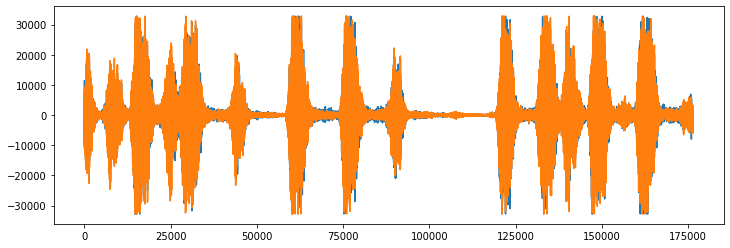

In [14]:
#pd.set_option('display.max_columns', None)
#
#appended = []
#for i in range(1, 11):
#    appended.append(us8k_data[us8k_data.fold == i]['class'].value_counts())
#
#class_distribution = pd.DataFrame(appended)
#class_distribution = class_distribution.reset_index()
#class_distribution['index'] = ["fold" + str(x) for x in range(1, 11)]
#path, label = path_class(file_to_test)
#
#wav_plotter(path, label)